In [1]:
import pandas as pd
from google.colab import drive
from pydrive.drive import GoogleDrive
import os
import shutil
import random
from matplotlib import pyplot
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten
from keras.models import  Model
from keras.applications.resnet import ResNet50, preprocess_input

#mount drive and unzip folder containing images
drive.mount('/content/gdrive')
!unzip gdrive/My\ Drive/archive.zip > /dev/null
print("Total Images: {}".format(len([name for name in os.listdir('ISIC_2019_Training_Input/ISIC_2019_Training_Input')])))

Mounted at /content/gdrive
Total Images: 25333


In [2]:
#create dataframe for each class melanoma, basal cell carcinoma, seborrheic keratosis
def OrganizeImages():
  df_gt = pd.read_csv ('ISIC_2019_Training_GroundTruth.csv')
  df_meta = pd.read_csv ('ISIC_2019_Training_Metadata.csv')

  df_mel = df_gt.loc[(df_gt['MEL'] == 1)]
  df_bcc = df_gt.loc[(df_gt['BCC'] == 1)]
  df_bkl = df_gt.loc[(df_gt['BKL'] == 1)]

  return df_mel, df_bcc, df_bkl

In [3]:
#only extract images coresponding to melanoma, basal cell carcinoma, seborrheic keratosis and move them into corresponding folders
def ExtractImages(df, name):
  dir = name + "/" + name
  os.mkdir(name)
  os.mkdir(dir)

  for index, row in df.iterrows():
    image = "ISIC_2019_Training_Input/ISIC_2019_Training_Input/{}.jpg".format(row['image'])
    shutil.move(image, dir)

  print("Total " + name + " images: {}".format(len([name for name in os.listdir(dir)])))

In [4]:
#splitting data into train, validation, testing and move them into corresponding folders
def SplitData(name, training, validation, test):
  dir = name + "/" + name
  length = len([name for name in os.listdir(dir)])
  train_size = round(length * training)
  validation_size = round(length * validation)
  test_size = round(length * test)

  try:
    os.mkdir(name + '/train')
    os.mkdir(name + '/validation')
    os.mkdir(name + '/test')
    os.mkdir(name + '/train/' + name)
    os.mkdir(name + '/validation/' + name)
    os.mkdir(name + '/test/' + name)
  except OSError as e:
    print("Error: {}.\nContinuing...".format(e.strerror))

  end_index = 0
  names = [name for name in os.listdir(dir)]
  for i in range(train_size):
    image = dir + "/{}".format(names[i])
    shutil.move(image, name + '/train/' + name)
    end_index = i
  
  for i in range(end_index + 1, end_index + validation_size):
    image = dir + "/{}".format(names[i])
    shutil.move(image, name + '/validation/' + name)
    end_index = i

  for i in range(end_index + 1, end_index + test_size):
    image = dir + "/{}".format(names[i])
    shutil.move(image, name + '/test/' + name)

  print_str = name + ":\n\tTrain Size: {}\n\tValidation Size: {}\n\tTest Size: {}\n"
  print(print_str.format(len([name for name in os.listdir(name + '/train/' + name)]), len([name for name in os.listdir(name + '/validation/' + name)]), len([name for name in os.listdir(name + '/test/' + name)])))

In [5]:
#balance classes
def ClassBalance(train):
  counter = Counter(train.classes)
  max_val = float(max(counter.values()))
  class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}

In [6]:
train_arg_params = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    zca_epsilon = 1e-06,
    rotation_range = 90,
    width_shift_range = [-30, 30],
    height_shift_range = [-30, 30],
    brightness_range = None,
    shear_range = 0.0,
    zoom_range = 0.0,
    channel_shift_range = 0.0,
    fill_mode = 'nearest',
    cval = 0.0,
    horizontal_flip = True,
    vertical_flip = True,
    rescale = 1./255,
    preprocessing_function = preprocess_input,
    data_format = None,
    validation_split = 0.0,
    dtype = None
)

test_arg_params = ImageDataGenerator(preprocessing_function=preprocess_input)

In [14]:
def ShowExampleArg(name, count):
  #if folder exits (already example images), delete and create new set
  try:
    os.mkdir(name + "/ExampleArg/")
    os.mkdir(name + "/ExampleArg/" + name)
  except OSError as e:
    print("Deleting dir {}".format(name + "/ExampleArg"))
    shutil.rmtree(name + "/ExampleArg/")
    print("Creating dir {}".format(name + "/ExampleArg/" + name))
    os.mkdir(name + "/ExampleArg/")
    os.mkdir(name + "/ExampleArg/" + name)

  dir = name + "/train/" + name
  length = len([name for name in os.listdir(dir)])
  names = [name for name in os.listdir(dir)]

  #find a random integer that won't cause out of index error
  rand_int = random.randint(0, length)
  while (rand_int + count > length):
    rand_int = random.randint(0, length)

  #moves example images to different folder
  for i in range(rand_int, rand_int + count):
    image = dir + "/{}".format(names[i])
    target = name + "/ExampleArg/" + name + "/" + str(names[i])
    shutil.copyfile(image, target)

  #start argumentation
  examples = train_arg_params.flow_from_directory(name + '/ExampleArg', target_size = inputSize[0:2])

  #display
  sub_plots = list(range(1, (count * 8) + 1))
  fig = pyplot.figure(figsize=(50, 50))

  for img in range(0, count * 8):
    x,y = examples.next()
    image = x[0]
    sub = fig.add_subplot(8,8, sub_plots[img])
    sub.imshow(image)
  pyplot.show()

In [8]:
#organize and extract melanoma, basal cell carcinoma, seborrheic keratosis into seperate folders 
df_mel, df_bcc, df_bkl = OrganizeImages()
ExtractImages(df_mel, 'MEL')
ExtractImages(df_bcc, 'BCC')
ExtractImages(df_bkl, 'BKL')

#split data into training, validatin, testing
training = 0.7
validation = 0.15
test = 0.15
inputSize= [224, 224, 3]

SplitData('MEL', training, validation, test)
SplitData('BCC', training, validation, test)
SplitData('BKL', training, validation, test)

Total MEL images: 4522
Total BCC images: 3323
Total BKL images: 2624
MEL:
	Train Size: 3165
	Validation Size: 677
	Test Size: 677

BCC:
	Train Size: 2326
	Validation Size: 497
	Test Size: 497

BKL:
	Train Size: 1837
	Validation Size: 393
	Test Size: 393



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Deleting dir BKL/ExampleArg
Creating dir BKL/ExampleArg/BKL
Found 1 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


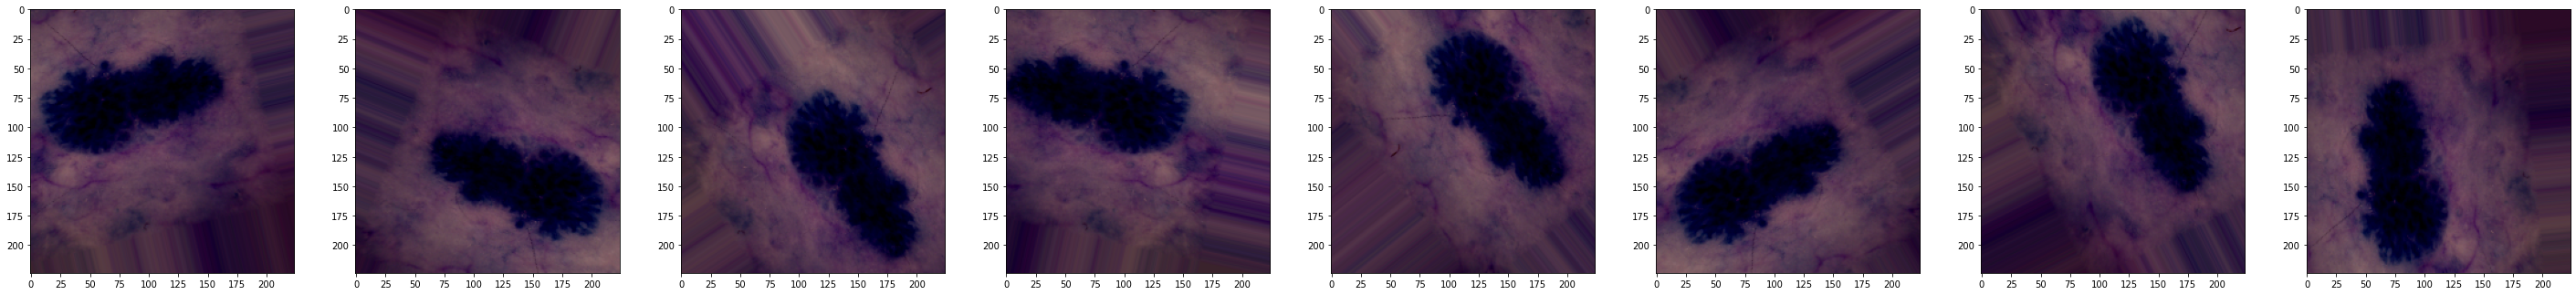

In [24]:
ShowExampleArg('BKL', 1)